[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1d6pJ24hRORxupbt8-zt6zjKYC6JNSDRG?usp=sharing)

# ML Mumbai Notebook
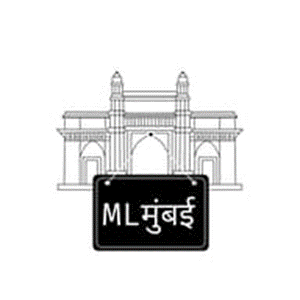

## Install Dependencies
Documentation: [LangChain](https://python.langchain.com/docs/get_started/introduction), [langchain-groq](https://pypi.org/project/langchain-groq/)

This cell installs the required packages for LangChain and the Groq integration.


In [ ]:
# Install langchain and langchain-groq packages
!pip install langchain langchain_groq

## Import Libraries
Documentation: [LangChain Groq](https://python.langchain.com/docs/integrations/chat/groq/)

You can also use other Chat Models as well [Chat Models](https://python.langchain.com/docs/integrations/chat/)


In [ ]:
# Import ChatGroq for interacting with the Groq API
from langchain_groq import ChatGroq
import os

## Set API Key

This cell sets the GROQ_API_KEY environment variable for authentication with the Groq API.

[Get your API Key](https://console.groq.com/authenticate/login?stytch_token_type=oauth&token=tC7Xf5m70dyX6m7PHeF_QtU-Dea5ygKEZmBtmAh0dubP)


In [ ]:
# Set the GROQ_API_KEY environment variable
os.environ["GROQ_API_KEY"] = ""

## Initialize Language Model
Documentation: [Models available to use in Groq](https://console.groq.com/docs/models)

This cell initializes the ChatGroq model with specified parameters.


In [ ]:
# Initialize the ChatGroq model with LLaMA 3.1 8B model and temperature setting
llm = ChatGroq(
    model="llama-3.1-8b-instant",  # Specify the model to use
    temperature=0.9,  # Set temperature for response randomness
)

## Define Data Models
Documentation: [Pydantic](https://docs.pydantic.dev/latest/)
This cell defines Pydantic models for structuring reasoning steps and paths.


In [ ]:
# Import necessary modules for data modeling
import uuid
from pydantic import BaseModel, Field
from typing import List

# Define a model for individual reasoning steps
class ReasoningStep(BaseModel):
    id: uuid.UUID = Field(default_factory=uuid.uuid4, description="Unique identifier for the reasoning step")
    step: str = Field(description="Description of the reasoning step")

# Define a model for a reasoning path containing multiple steps
class ReasoningPath(BaseModel):
    steps: List[ReasoningStep] = Field(description="List of reasoning steps")
    answer: str = Field(description="Final answer of the path")

# Define a model for multiple reasoning paths
class ReasoningPaths(BaseModel):
    paths: List[ReasoningPath] = Field(description="List of reasoning paths")

## Define Prompt Template
Documentation: [PromptTemplate](https://python.langchain.com/api_reference/core/prompts/langchain_core.prompts.prompt.PromptTemplate.html)

This cell defines a prompt template for generating multiple reasoning paths for a given problem.


In [ ]:
# Import PromptTemplate for creating structured prompts
from langchain.prompts import PromptTemplate

# Define a prompt template for generating reasoning paths
generate_thoughts_prompt = PromptTemplate(
    input_variables=["problem"],
    template="""
    You are a mathematical reasoning expert. For the given problem, generate multiple distinct reasoning paths to solve it. Each path should be a step-by-step explanation leading to the solution. Output in JSON format as follows:
    {{
        "paths": [
            {{
                "steps": [{{"step": "Description of step 1"}}, {{"step": "Description of step 2"}}, ...],
                "answer": "Final answer"
            }},
            {{
                "steps": [{{"step": "Description of step 1"}}, {{"step": "Description of step 2"}}, ...],
                "answer": "Final answer"
            }},
            {{
                "steps": [{{"step": "Description of step 1"}}, {{"step": "Description of step 2"}}, ...],
                "answer": "Final answer"
            }}
        ]
    }}

    Problem: {problem}
    Guidelines:
    - The final answer should be a concise solution to the problem without unnecessary details.
    """
)

## Define Reasoning Function
Documentation: [OutputFixingParser](https://python.langchain.com/api_reference/langchain/output_parsers/langchain.output_parsers.fix.OutputFixingParser.html), [JsonOutputParser](https://python.langchain.com/api_reference/core/output_parsers/langchain_core.output_parsers.json.JsonOutputParser.html)

This cell defines a function to generate reasoning paths using the language model and parse the output.


In [ ]:
# Import parsers for handling model output
from langchain.output_parsers import OutputFixingParser
from langchain_core.output_parsers import JsonOutputParser

# Define a function to generate reasoning paths for a given problem
def generate_thoughts(problem, llm):
    # Create a chain combining the prompt, model, and output parser
    generate_chain = generate_thoughts_prompt | llm | OutputFixingParser.from_llm(
        parser=JsonOutputParser(pydantic_object=ReasoningPaths), llm=llm, max_retries = 3
    )
    # Invoke the chain with the input problem
    result = generate_chain.invoke({"problem": problem})

    return result

## Run the Reasoning System
This cell prompts the user for a mathematical problem and generates reasoning paths using the defined function.

[GSM8K Dataset](https://huggingface.co/datasets/openai/gsm8k)

Some Example Inputs
```
Weng earns $12 an hour for babysitting. Yesterday, she just did 50 minutes of babysitting. How much did she earn?
```
Answer : 10

```
Joy can read 8 pages of a book in 20 minutes. How many hours will it take her to read 120 pages?
```

Answer : 5

In [ ]:
from IPython.display import JSON
# Prompt the user for a mathematical problem and generate reasoning paths
result = generate_thoughts(input("Enter a Mathematical Problem : "), llm)
JSON(result, expanded=True)

Enter a Mathematical Problem : Weng earns $12 an hour for babysitting. Yesterday, she just did 50 minutes of babysitting. How much did she earn?


<IPython.core.display.JSON object>